In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
from tqdm.auto import tqdm
import os

import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

sns.set(font_scale=1, style='darkgrid', palette='Set2')

### Подготовка данных

#### Исследуем номера:
Посмотрим какие символы возможны на разных позициях номера:

In [4]:
TRAIN_PATH = 'CCPD2019-dl1/train/'
img_names = os.listdir(TRAIN_PATH)
numbers = list(map(lambda s: s.split('-')[1].split('.')[0], img_names))

for i in range(len(numbers[0])):
    print(f'{i}: {np.unique(list(map(lambda s: s[i], numbers)))}')

0: ['云' '京' '冀' '吉' '宁' '川' '新' '晋' '桂' '沪' '津' '浙' '渝' '湘' '琼' '甘' '皖' '粤'
 '苏' '蒙' '藏' '豫' '贵' '赣' '辽' '鄂' '闽' '陕' '青' '鲁' '黑']
1: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'J' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T'
 'U' 'V' 'W' 'X' 'Y' 'Z']
2: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'J' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
3: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
4: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'J' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
5: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'J' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
6: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'J' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


Как видим нулевая позиция явно отличается от всех следующих, поэтому в модели сделаем две головы: одна классифицирует иероглифы для первой позиции, вторая классифицирует латинские буквы и цифры для остальных позиций.

In [5]:
HIEROGLYPHS = np.unique(list(map(lambda s: s[0], numbers)))
OTHER = np.unique(sum((list(map(lambda s: s[i], numbers)) for i in range(1, 7)), []))
CNT_HIEROGLYPHS = len(HIEROGLYPHS)
CNT_OTHER = len(OTHER)

hyeroglyphs2idx = {h: i for i, h in enumerate(HIEROGLYPHS)}
other2idx = {o: i for i, o in enumerate(OTHER)}

HIEROGLYPHS, CNT_HIEROGLYPHS, OTHER, CNT_OTHER

(array(['云', '京', '冀', '吉', '宁', '川', '新', '晋', '桂', '沪', '津', '浙', '渝',
        '湘', '琼', '甘', '皖', '粤', '苏', '蒙', '藏', '豫', '贵', '赣', '辽', '鄂',
        '闽', '陕', '青', '鲁', '黑'], dtype='<U1'),
 31,
 array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
        'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q',
        'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1'),
 35)

#### Реализуем датасеты

In [30]:
def get_transforms(mode):
    default = A.Compose([
        A.Resize(64, 32 * 7),   # plate shape ratio ~ 1:3 ~ 2:7
        A.Normalize(),
        ToTensorV2()
    ])
    
    if mode != 'train':
        return default
    
    return A.Compose([
        A.Blur(blur_limit=(1, 3), p=0.5),
        A.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Perspective(scale=0.025, p=0.3),
        default
    ])


class PlateNumbers(torch.utils.data.Dataset):
    def __init__(self, data_path, images=None, transform=None, return_filename=False):
        self.data_path = data_path
        self.transform = transform
        self.return_filename = return_filename

        if images is None:
            self.images = os.listdir(data_path)
        else:
            self.images = images

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = cv2.cvtColor(cv2.imread(os.path.join(self.data_path, img_name)), cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        number = img_name.split('-')[1].split('.')[0]
        first = torch.tensor([hyeroglyphs2idx[number[0]]])
        tail = torch.tensor([other2idx[number[i]] for i in range(1, 7)])

        if self.return_filename:
            return image, (first, tail), img_name
        return image, (first, tail)

Создадим три датасета и даталоадера для обучения, валидации и тестирования:

In [32]:
TRAIN_PATH = 'CCPD2019-dl1/train/'
TEST_PATH = 'CCPD2019-dl1/test/'
train_val_frac = 0.9
batch_size = 64

img_names = os.listdir(TRAIN_PATH)
np.random.shuffle(img_names)
border = int(len(img_names) * train_val_frac)
train_images = img_names[:border]
val_images = img_names[border:]

train_ds = PlateNumbers(TRAIN_PATH, images=train_images, transform=get_transforms('train'))
val_ds = PlateNumbers(TRAIN_PATH, images=val_images, transform=get_transforms('val'))
test_ds = PlateNumbers(TEST_PATH, transform=get_transforms('test'), return_filename=True)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [8]:
len(train_ds), len(val_ds), len(test_ds)

(179982, 19998, 9999)

Проверим, что всё работает ожидаемо:

Number: 皖A26Y56


torch.Size([3, 64, 224])

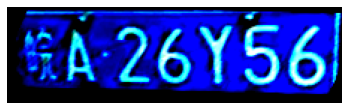

In [9]:
plt.imshow(train_ds[0][0].permute(1, 2, 0))
plt.axis('off')
number = train_ds[0][1]
print(f'Number: {HIEROGLYPHS[number[0]]}{"".join(OTHER[number[1]])}')
train_ds[0][0].shape

(Такой странный цвет из-за нормализации)

### Создание и обучение модели

#### Немного мыслей о первой упростощенной модели:

FCNN было бы разумно использовать для распознавания текстов неизвестной заранее длины, поскольку этот способ дает по сути скользящее окно по изображению, на котором вычисляется вектор признаков. При размере окна $\approx$ размеру одного символа, мы бы как раз получали вектор признаки символов. Однако тут есть два момента:  
- кажется такую модель было бы лучше предобучить на датасете из отдельных символов, как обычную CNN и потом конвертировать ее в FCNN (у нас же такого датасета нет) 
- естественно это окно не всегда попадает на символ, иногда между ними, иногда в нем может оказаться два узких символа, то есть надо еще уметь предсказывать отсутствие символа и для узких символов понимать, что раньше его уже распознавали. Это увеличивает вероятность ошибки

В нашей же задаче все тексты фиксированной длины - 7 символов, поэтому тут можно использовать обычную CNN, на выходе которой будет матрица признаков размера $(hidden\_size, 1, 7)$. Скорее всего тут это более эффективно, чем FCNN, как минимум из-за того, что нет проблем, описанных во втором пункте


Попробуем вначале обучить простую модель без LSTM, мотивация такая: если символы распределены независимо друг от друга (а в номерах это скорее всего так), то LSTM бессмысленен, так как он нужен именно для учета связей между соседними объектами

#### Создаем модель:

In [10]:
class SimpleNumbersOCR(pl.LightningModule):
    def __init__(self, dropout_p=0.2):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),   # 64 x 32*7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout_p),
            nn.MaxPool2d(2, 2),               # 32 x 16*7
            
            nn.Conv2d(32, 64, 3, padding=1, stride=(2, 1)),  # 16 x 16*7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(dropout_p),
            nn.MaxPool2d(2, 2),               # 8 x 8*7
            
            nn.Conv2d(64, 128, 3, padding=1), # 8 x 8*7
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(dropout_p),
            nn.MaxPool2d(2, 2),               # 4 x 4*7
            
            nn.Conv2d(128, 256, 3, padding=1, stride=2),    # 2 x 2*7
            nn.ReLU(),
            nn.MaxPool2d(2, 2),               # 1 x 1*7
        )
        
        self.hieroglyphs_cls = nn.Linear(256, len(HIEROGLYPHS))
        self.other_cls = nn.Linear(256, len(OTHER))
        
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, x):
        out = self.cnn_layers(x).squeeze(2).permute(0, 2, 1)
        
        first = self.hieroglyphs_cls(out[:, :1])
        tail = self.other_cls(out[:, 1:])
        
        return first, tail
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5),
                "interval": "epoch",
            },
        }
    
    def training_step(self, batch, batch_idx):
        x, (first, tail) = batch
        
        self.train()
        first_logits, tail_logits = self(x)
    
        first_loss = self.loss(first_logits.view(-1, CNT_HIEROGLYPHS), first.view(-1))
        tail_loss = self.loss(tail_logits.view(-1, CNT_OTHER), tail.view(-1))
        loss = (first_loss + 6 * tail_loss) / 7
        
        result = torch.cat([first_logits.argmax(-1), tail_logits.argmax(-1)], dim=1)
        is_true = (result == torch.cat([first, tail], dim=1))
        accuracy = is_true.all(dim=1).float().mean()
        char_accuracy = is_true.float().mean()
        
        self.log('train_batch/loss', loss, prog_bar=True, on_epoch=False, on_step=True)
        self.log('train_batch/first_loss', first_loss, prog_bar=False, on_epoch=False, on_step=True)
        self.log('train_batch/tail_loss', tail_loss, prog_bar=False, on_epoch=False, on_step=True)
        self.log('train_batch/accuracy', accuracy, prog_bar=False, on_epoch=False, on_step=True)
        self.log('train_batch/char_accuracy', char_accuracy, prog_bar=False, on_epoch=False, on_step=True)
        
        return {'loss': loss, 'train/first_loss': first_loss, 'train/tail_loss': tail_loss, 
                'train/accuracy': accuracy, 'train/char_accuracy': char_accuracy}
    
    def validation_step(self, batch, batch_idx):
        x, (first, tail) = batch
        
        self.eval()
        with torch.no_grad():
            first_logits, tail_logits = self(x)
    
        first_loss = self.loss(first_logits.view(-1, CNT_HIEROGLYPHS), first.view(-1))
        tail_loss = self.loss(tail_logits.view(-1, CNT_OTHER), tail.view(-1))
        loss = (first_loss + 6 * tail_loss) / 7
        
        result = torch.cat([first_logits.argmax(-1), tail_logits.argmax(-1)], dim=1)
        is_true = result == torch.cat([first, tail], dim=1)
        accuracy = is_true.all(dim=1).float().mean()
        char_accuracy = is_true.float().mean()
        
        return {'val/loss': loss, 'val/first_loss': first_loss, 'val/tail_loss': tail_loss, 
                'val/accuracy': accuracy, 'val/char_accuracy': char_accuracy}
    
    def training_epoch_end(self, outputs):
        for k in outputs[0].keys():
            if not k.startswith('val/'):
                m = torch.stack([x[k] for x in outputs]).mean()
                if k == 'loss':
                    k = 'train/loss'
                self.log(k, m, prog_bar=True, on_epoch=True, on_step=False)
        
    def validation_epoch_end(self, outputs):
        for k in outputs[0].keys():
            if k.startswith('val/'):
                m = torch.stack([x[k] for x in outputs]).mean()
                self.log(k, m, prog_bar=True, on_epoch=True, on_step=False)

#### Обучаем модель:

In [11]:
model = SimpleNumbersOCR(dropout_p=0.2)

In [ ]:
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="mps", 
    devices=1,
    log_every_n_steps=50,
    logger=WandbLogger(project="tinkoff-ocr", name="simple ocr model"),
    val_check_interval=0.5,
)

trainer.fit(model, train_dl, val_dl)
torch.save(model.state_dict(), 'simple_model.pth')

wandb.finish()

wandb: Currently logged in as: aleks311001. Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | cnn_layers      | Sequential       | 388 K 
1 | hieroglyphs_cls | Linear           | 8.0 K 
2 | other_cls       | Linear           | 9.0 K 
3 | loss            | CrossEntropyLoss | 0     
-----------------------------------------------------
405 K     Trainable params
0         Non-trainable params
405 K     Total params
1.623     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/aleks311001/miniforge3/envs/shad-cv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/aleks311001/miniforge3/envs/shad-cv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train/accuracy,▁████
train/char_accuracy,▁████
train/first_loss,█▂▁▁▁
train/loss,█▁▁▁▁
train/tail_loss,█▁▁▁▁
train_batch/accuracy,▁▆▇█████████████████████████████████████
train_batch/char_accuracy,▁▇██████████████████████████████████████
train_batch/first_loss,█▁▅▁▃▂▁▁▁▁▁▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁
train_batch/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_batch/tail_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Посмотреть на метрики в процессе обучения можно [тут](https://wandb.ai/aleks311001/tinkoff-ocr/reports/Tinkoff-OCR--VmlldzozMjQwMzky?accessToken=r2djmvsmbgyy3mf02bm7ooromyqh1ewph8496u9n36ga2l73bi2z30qnuwzrrvrz)

#### Посчитаем качество на тесте

In [50]:
def evaluate(model, test_dl):
    model.eval()
    preds = []
    g_true = []
    
    for x, (first, tail), _ in tqdm(test_dl):
        with torch.no_grad():
            first_logits, tail_logits = model(x)
        
        preds.append(
            np.apply_along_axis(
                lambda x: ''.join(x), 
                axis=1, 
                arr=np.concatenate([HIEROGLYPHS[first_logits.argmax(-1)], OTHER[tail_logits.argmax(-1)]], axis=1)
            )
        )
        g_true.append(
            np.apply_along_axis(
                lambda x: ''.join(x), 
                axis=1, 
                arr=np.concatenate([HIEROGLYPHS[first], OTHER[tail]], axis=1)
            )
        )
    
    preds = np.concatenate(preds)
    g_true = np.concatenate(g_true)
    
    accuracy = (preds == g_true).mean()
    cer = torchmetrics.CharErrorRate()(preds, g_true)
    
    return {'accuracy': accuracy, 'CER': cer}


In [ ]:
result = evaluate(model, test_dl)
result

  0%|          | 0/157 [00:00<?, ?it/s]

{'accuracy': 0.9715971597159716, 'CER': tensor(0.0051)}

#### Попробуем добавить LSTM

С теми же размерностями скрытых слоев, что 

In [18]:
class LSTMNumbersOCR(SimpleNumbersOCR):
    def __init__(self, dropout_p=0.2):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),   # 64 x 32*7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout_p),
            nn.MaxPool2d(2, 2),               # 32 x 16*7
            
            nn.Conv2d(32, 64, 3, padding=1, stride=(2, 1)),  # 16 x 16*7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(dropout_p),
            nn.MaxPool2d(2, 2),               # 8 x 8*7
            
            nn.Conv2d(64, 128, 3, padding=1), # 8 x 8*7
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(dropout_p),
            nn.MaxPool2d(2, 2),               # 4 x 4*7
            
            nn.Conv2d(128, 256, 3, padding=1, stride=2),    # 2 x 2*7
            nn.ReLU(),
            nn.MaxPool2d(2, 2),               # 1 x 1*7
        )
        
        self.lstm = nn.LSTM(256, 128, num_layers=2, batch_first=True, dropout=dropout_p, bidirectional=True)
        
        self.hieroglyphs_cls = nn.Linear(128 * 2, len(HIEROGLYPHS))
        self.other_cls = nn.Linear(128 * 2, len(OTHER))
        
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, x):
        out = self.cnn_layers(x).squeeze(2).permute(0, 2, 1)
        
        out, _ = self.lstm(out)
        
        first = self.hieroglyphs_cls(out[:, :1])
        tail = self.other_cls(out[:, 1:])
        
        return first, tail
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=8e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5),
                "interval": "epoch",
            },
        }


In [26]:
model_lstm = LSTMNumbersOCR(dropout_p=0.2)

In [22]:
logger=WandbLogger(project="tinkoff-ocr", name="lstm ocr model")
logger.watch(model_lstm, log='all')

trainer = pl.Trainer(
    max_epochs=7,
    accelerator="cuda", 
    devices=1,
    log_every_n_steps=50,
    logger=logger,
    val_check_interval=0.5,
)

trainer.fit(model_lstm, train_dl, val_dl)
torch.save(model_lstm.state_dict(), 'lstm_model.pth')

wandb.finish()

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params
-----------------------------------------------------
0 | cnn_layers      | Sequential       | 388 K 
1 | hieroglyphs_cls | Linear           | 8.0 K 
2 | other_cls       | Linear           | 9.0 K 
3 | loss            | CrossEntropyLoss | 0     
4 | lstm            | LSTM             | 790 K 
-----------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██████
train/accuracy,▁██████
train/char_accuracy,▁██████
train/first_loss,█▂▁▁▁▁▁
train/loss,█▁▁▁▁▁▁
train/tail_loss,█▁▁▁▁▁▁
train_batch/accuracy,▁███████████████████████████████████████
train_batch/char_accuracy,▁███████████████████████████████████████
train_batch/first_loss,█▁▁▃▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
train_batch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_batch/tail_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Посмотреть на метрики в процессе обучения можно [тут](https://wandb.ai/aleks311001/tinkoff-ocr/reports/Tinkoff-OCR--VmlldzozMjQwMzky?accessToken=r2djmvsmbgyy3mf02bm7ooromyqh1ewph8496u9n36ga2l73bi2z30qnuwzrrvrz)

In [28]:
result = evaluate(model_lstm, test_dl)
result

  0%|          | 0/157 [00:00<?, ?it/s]

{'accuracy': 0.9837983798379838, 'CER': tensor(0.0028)}

Точность получилась на 1% лучше, CER почти в 2 раза меньше. Получается либо предположение было не верным и между символами в номерах всё же есть какая-то зависимость, либо же качество улучшилось просто за счет добавления параметров и слоев. Однако с ростом качества сильно выросло и время работы модели, что было ожидаемо, так как LSTM работает совсем не быстро

### Анализ ошибок модели

Анализ ошибок будем проводить для последней, лучшей модели с LSTM

In [53]:
model_lstm.eval()
preds = []
g_true = []
filenames = []

for x, (first, tail), filename in tqdm(test_dl):
    with torch.no_grad():
        first_logits, tail_logits = model_lstm(x)
    
    preds.append(
        np.apply_along_axis(
            lambda x: ''.join(x), 
            axis=1, 
            arr=np.concatenate([HIEROGLYPHS[first_logits.argmax(-1)], OTHER[tail_logits.argmax(-1)]], axis=1)
        )
    )
    g_true.append(
        np.apply_along_axis(
            lambda x: ''.join(x), 
            axis=1, 
            arr=np.concatenate([HIEROGLYPHS[first], OTHER[tail]], axis=1)
        )
    )
    filenames.append(filename)

preds = np.concatenate(preds)
g_true = np.concatenate(g_true)
filenames = np.concatenate(filenames)

cer_list = np.array([torchmetrics.functional.char_error_rate(pred, t) for pred, t in zip(preds, g_true)])


  0%|          | 0/157 [00:00<?, ?it/s]

In [65]:
sorted_idxs = np.argsort(cer_list)[::-1]
sorted_cer = cer_list[sorted_idxs]
sorted_cer[:25]

array([0.71428573, 0.71428573, 0.5714286 , 0.42857143, 0.42857143,
       0.42857143, 0.42857143, 0.42857143, 0.42857143, 0.2857143 ,
       0.2857143 , 0.2857143 , 0.2857143 , 0.2857143 , 0.2857143 ,
       0.2857143 , 0.2857143 , 0.2857143 , 0.2857143 , 0.2857143 ,
       0.2857143 , 0.14285715, 0.14285715, 0.14285715, 0.14285715],
      dtype=float32)

Посмотрим на все изображения с $CER \geqslant 0.285$, их 21:

In [63]:
top_k = 21
bad_images = filenames[sorted_idxs][:top_k]

In [78]:
from matplotlib.font_manager import FontProperties

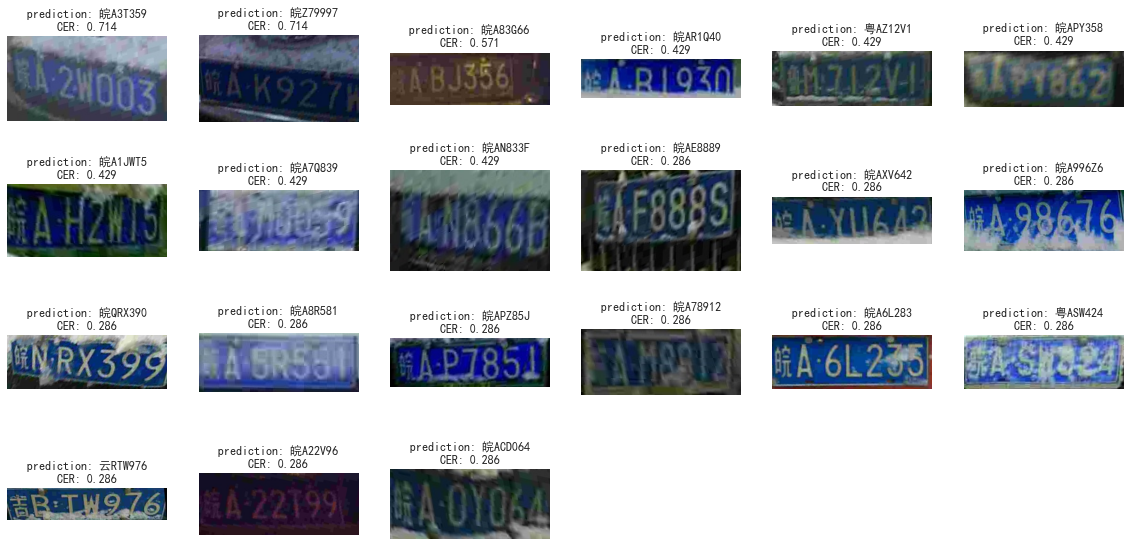

In [86]:
prop = FontProperties()
prop.set_file('SimHei.ttf')   # Для отображения иероглифов

plt.figure(figsize=(20, 10))

for i, (cer, img_name, pred) in enumerate(zip(sorted_cer, bad_images, preds[sorted_idxs])):
    plt.subplot(4, 6, i + 1)
    image = cv2.cvtColor(cv2.imread(os.path.join('CCPD2019-dl1/test', img_name)), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'prediction: {pred}\nCER: {cer:.3f}', fontproperties=prop)
    plt.axis('off')

Как видно плохораспознанные номера и правда довольно плохого качества: 
- первые два под очень кривым ракурсом, ведь модель обучалась в основном на картинках, в которых номер занимает почти всё простанство
- далее идет номер с необычным цветом и большим пустым местом справа
- также наблюдается проблема загрязненности номера или смазанности изображения

Решить первую проблему можно, например, вырезая из исходных изображений не ровно задетекченную область (которая не всегда детектится идеально как выяснилось на этих изображениях), а с некоторой рандомной рамкой.  
Проблемы второго и третьего пункта можно решать разными способами: 
- увеличивать в тренировочных данных подобные номера
- попытаться сделать реалистичную аугментацию: как-то редактировать цвет, чтобы с некоторой вероятностью синий менялся на коричневый; увеличить коэффициент размытия; добавить в случайные места белые пятна

Еще раз финальные метрики: 
- Accuracy: $98.3%$
- CER: $0.0028$